## **Preparing Data**

In [1]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib python3.7 python3.7-minimal
0 upgraded, 4 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,530 kB of archives.
After this operation, 23.3 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.7-minimal amd64 3.7.16-1+focal1 [588 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.7-minimal amd64 3.7.16-1+focal1 [1,808 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.7-stdlib amd64 3.7.16-1+focal1 [1,773 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.7 amd64 3.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [5]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 769kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 175kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 163kB/s]


In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [8]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different. 
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token. 
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [10]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [11]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## **Building the Model**

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [13]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, mask=None):
        
        ## TODO: write down the forward step
        batch_size = src.shape[0]
        seq_len = src.shape[1]

        token_embedding = self.tok_embedding(src)
        scaled_token_embedding = token_embedding * self.scale

        position_array = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        position_embedding = self.pos_embedding(position_array)

        src = scaled_token_embedding + position_embedding
        src = self.dropout(src)
        
        for layer in self.layers:
            src = layer(src, mask)
        
        return src

### Encoer layer

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self-Attention '''        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, mask=None):
        
        # TODO: write your code
        self_attention, _ = self.self_attention(src, src, src, mask)
        sub_layer_1 = self.self_attn_layer_norm(self.dropout(self_attention) + src)

        positionwise_feedforward = self.positionwise_feedforward(sub_layer_1)
        sub_layer_2 = self.ff_layer_norm(self.dropout(positionwise_feedforward) + sub_layer_1)
        
        return sub_layer_2

### Multi Head Attention Layer

In [39]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        # TODO: write your code
        self.INF = 1e9
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.W_Q = nn.Linear(hid_dim, hid_dim)
        self.W_K = nn.Linear(hid_dim, hid_dim)
        self.W_V = nn.Linear(hid_dim, hid_dim)
        self.W_O = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.softmax = nn.Softmax(dim=-1)

    def attention(self, Q, K, V, mask):
        # QK^T / sqrt(d_k)
        scaled_dot_product_attention = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # Create attention mask
        if mask is not None:
            scaled_dot_product_attention = scaled_dot_product_attention.masked_fill(mask == 0, -self.INF)

        # softmax(QK^T / sqrt(d_k))
        scaled_dot_product_attention = self.softmax(scaled_dot_product_attention)

        # Attention(Q, K, V) =  softmax(QK^T / sqrt(d_k))V
        attention = torch.matmul(self.dropout(scaled_dot_product_attention), V)
        
        return attention, scaled_dot_product_attention
    
    def make_multi_head(self, batch_size, Q, K, V):
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        return Q, K, V
        
    def forward(self, query, key, value, mask = None):
        
        # TODO: write your code
        batch_size = query.shape[0]

        Q = self.W_Q(query)
        K = self.W_K(key)
        V = self.W_V(value)

        Q, K, V = self.make_multi_head(batch_size, Q, K, V)

        x, attention = self.attention(Q, K, V, mask)

        # Concatenate heads
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)        
        x = self.W_O(x)
        
        return x, attention

### Position-wise Feedforward Layer

In [40]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        # TODO: write your code
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        # TODO: write your code
        # x * W1 + b1
        x = self.fc_1(x)
        # relu(x * W1 + b1)
        x = self.relu(x)
        x = self.dropout(x)
        # relu(x * W1 + b1)W2 + b2
        x = self.fc_2(x)
        
        return x

### Decoder 

In [41]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

       
        
    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        
        # TODO: write your code
        batch_size = tgt.shape[0]
        seq_len = tgt.shape[1]
        
        token_embedding = self.tok_embedding(tgt)
        scaled_token_embedding = token_embedding * self.scale

        position_array = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        position_embedding = self.pos_embedding(position_array)

        tgt = scaled_token_embedding + position_embedding
        tgt = self.dropout(tgt)
        
        for layer in self.layers:
            tgt, attention = layer(tgt, enc_src, tgt_mask, src_mask)
        
        output = self.fc_out(tgt)
        
        return output, attention

### Decoder Layer

In [42]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self Attention'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, tgt, enc_src, tgt_mask, src_mask):
        
        # TODO: write your code
        self_attention, _ = self.self_attention(tgt, tgt, tgt, tgt_mask)
        sub_layer_1 = self.self_attn_layer_norm(self.dropout(self_attention) + tgt)

        # Encoder Attention
        encoder_attention, attention = self.encoder_attention(sub_layer_1, enc_src, enc_src, src_mask)
        sub_layer_2 = self.enc_attn_layer_norm(self.dropout(encoder_attention) + sub_layer_1)

        positionwise_feedforward = self.positionwise_feedforward(sub_layer_2)
        sub_layer_3 = self.ff_layer_norm(self.dropout(positionwise_feedforward) + sub_layer_2)
        
        return sub_layer_3, attention

### Sequence-to-sequence model

In [43]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def get_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    
    def get_tgt_mask(self, tgt):
        seq_len = tgt.shape[1]
        pad_mask = (tgt != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        identity_mask = torch.ones(seq_len, seq_len).to(self.device)
        triangle_mask = torch.tril(identity_mask).bool()
        return triangle_mask & pad_mask

    def forward(self, src, tgt):
        
        ## TODO: write down the forward step
        src_mask = self.get_src_mask(src)
        tgt_mask = self.get_tgt_mask(tgt)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(tgt, enc_src, tgt_mask, src_mask)
                
        return output, attention

### Training the Seq2Seq Model

In [44]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [45]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


We initialize model weights

In [47]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [48]:
LEARNING_RATE = 0.0005
# LEARNING_RATE = 6e-4

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [49]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [50]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        # TODO: write down your training code here
        y_hat, attention = model(src, trg[:, :-1])

        y_dim = y_hat.shape[-1]
        output = y_hat.view(-1, y_dim)
        target = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
       
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation

In [51]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            
            # TODO: write down your training code here
            y_hat, attention = model(src, trg[:, :-1])

            y_dim = y_hat.shape[-1]
            output = y_hat.view(-1, y_dim)
            target = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, target)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [52]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [53]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 14s
	Train Loss: 4.302
	 Val. Loss: 3.101
Epoch: 02 | Time: 0m 14s
	Train Loss: 2.857
	 Val. Loss: 2.323
Epoch: 03 | Time: 0m 14s
	Train Loss: 2.247
	 Val. Loss: 1.955
Epoch: 04 | Time: 0m 14s
	Train Loss: 1.882
	 Val. Loss: 1.808
Epoch: 05 | Time: 0m 14s
	Train Loss: 1.629
	 Val. Loss: 1.696
Epoch: 06 | Time: 0m 14s
	Train Loss: 1.437
	 Val. Loss: 1.648
Epoch: 07 | Time: 0m 14s
	Train Loss: 1.286
	 Val. Loss: 1.618
Epoch: 08 | Time: 0m 14s
	Train Loss: 1.160
	 Val. Loss: 1.612
Epoch: 09 | Time: 0m 14s
	Train Loss: 1.049
	 Val. Loss: 1.634
Epoch: 10 | Time: 0m 14s
	Train Loss: 0.960
	 Val. Loss: 1.638


In [54]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1.646


### Inference and attention visualization

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [56]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
    
    # TODO: write your code 
    tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.get_src_mask(src)
    
    with torch.no_grad():
        enc_src = model.encoder(src, src_mask)
        decoded_words = [trg_field.vocab.stoi[trg_field.init_token]]

        for i in range(max_len):
            tgt = torch.LongTensor(decoded_words).unsqueeze(0).to(device)
            tgt_mask = model.get_tgt_mask(tgt)

            output, decoder_attentions = model.decoder(tgt, enc_src, tgt_mask, src_mask)

            pred_token = output.argmax(2)[:,-1].item()
            decoded_words.append(pred_token)

            if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
                break

    decoded_words = [trg_field.vocab.itos[i] for i in decoded_words]
    
    return decoded_words[1:], decoder_attentions

In [57]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')
        
        # Set up axes
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [58]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [59]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


<ipython-input-57-a780b7af5366>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-57-a780b7af5366>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


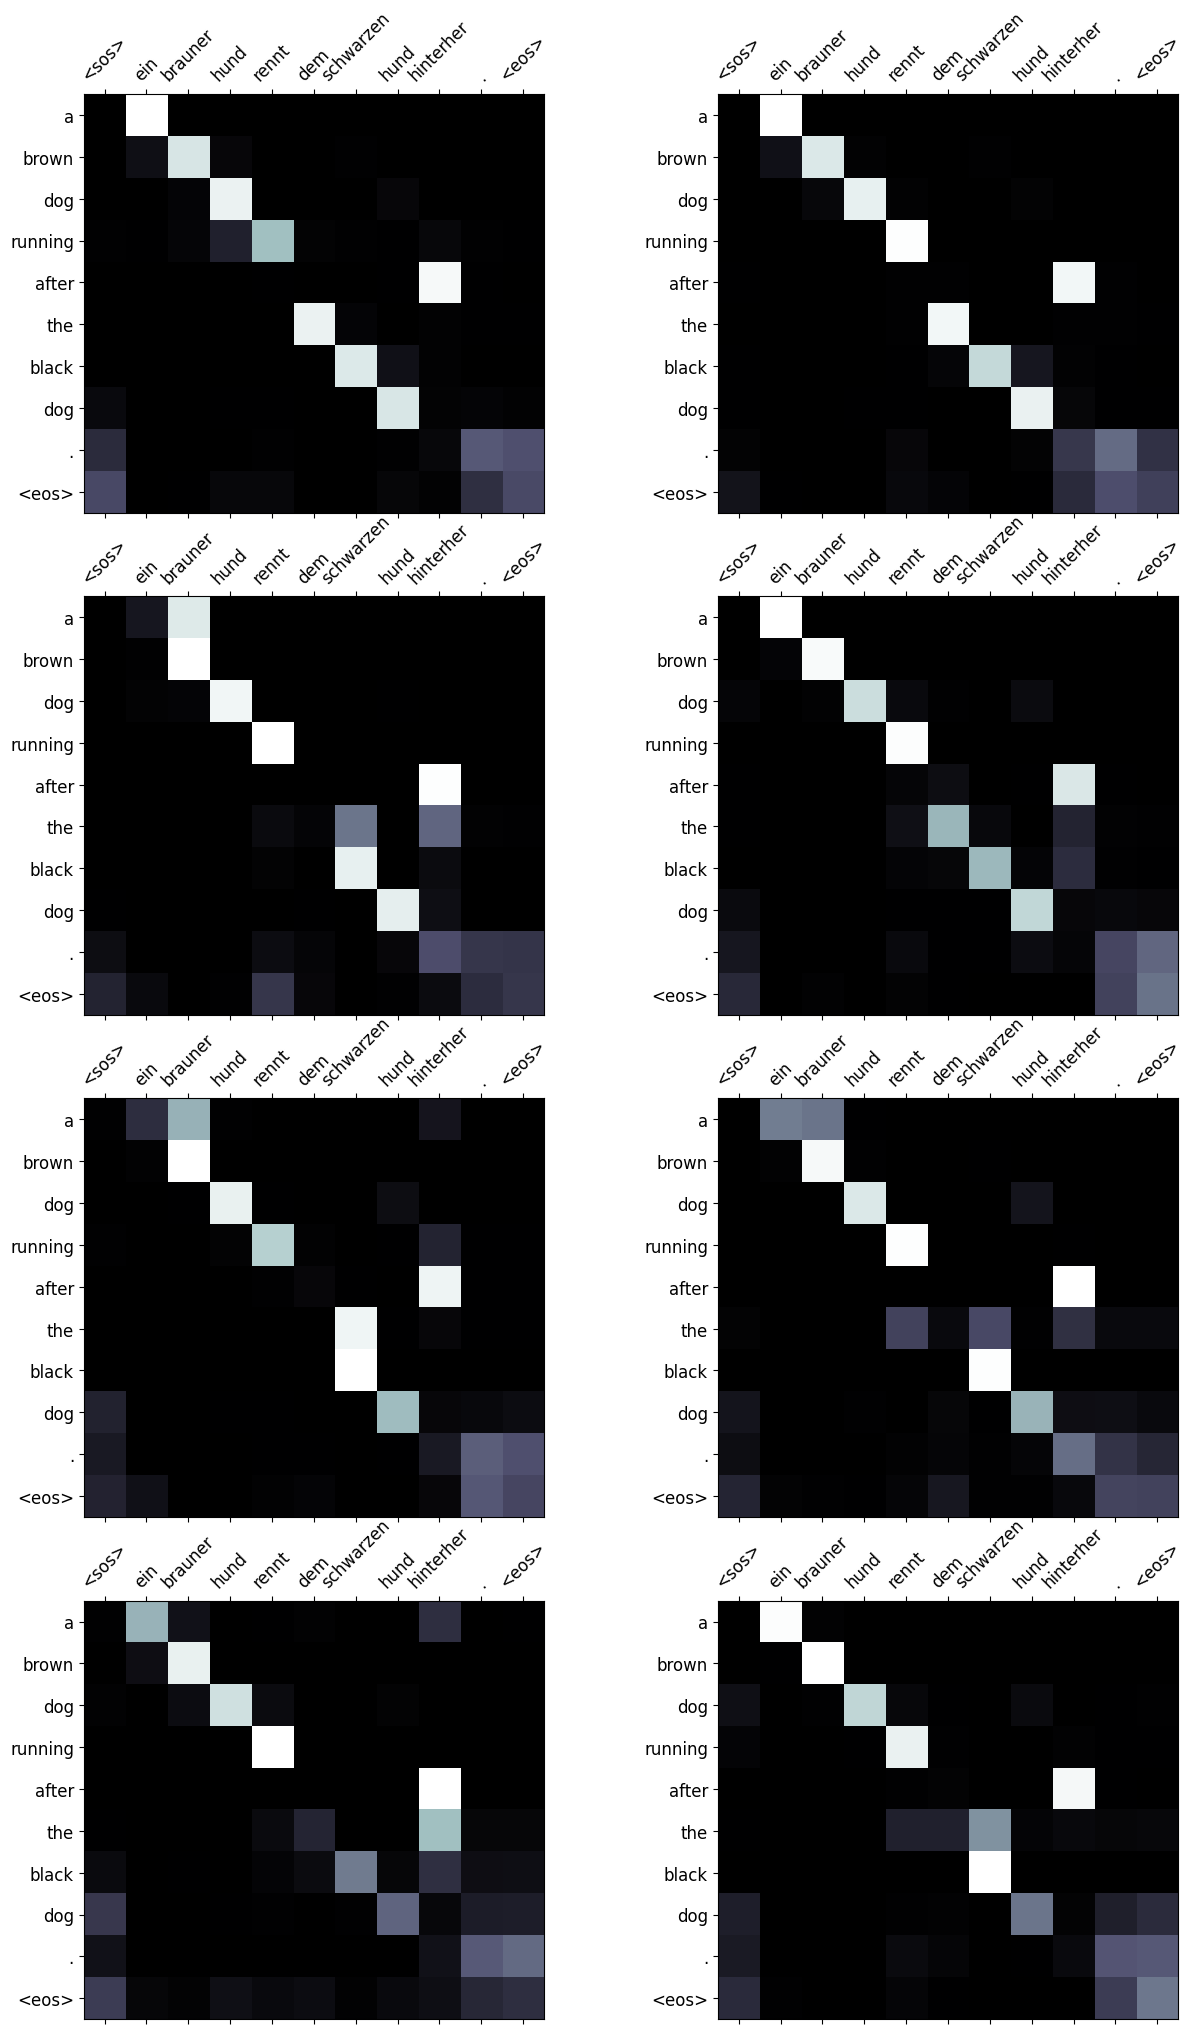

In [60]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [61]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [62]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.37
